# Neurite interactions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms

from neurorosettes import physics
from neurorosettes.subcellular import ObjectFactory

## Defining objects and interactions

In [3]:
# Define the mechanical parameters of the objects
factory = ObjectFactory(
    cell_radius=8.0,
    cell_interaction_factor=1.25,
    neurite_radius=1.0,
    neurite_interaction_factor=2.0,
    neurite_spring_constant=10.0,
    neurite_default_length=20.0,
)

# Define the mechanical parameters of the interactions
contact_function = physics.PotentialsContact(
    adhesion_coefficient=0.4, repulsion_coefficient=40.0, smoothness_factor=1
)

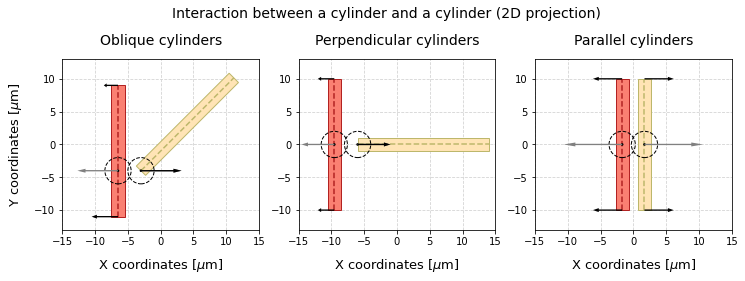

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes_names = ["Oblique cylinders", "Perpendicular cylinders", "Parallel cylinders"]
springs = [
    {
        "spring1_coordinates": np.array([-6.5, -11.0, 0.0]),
        "spring2_coordinates": np.array([-3.0, -4.0, 0.0]),
        "growth": np.array([1.0, 1.0, 0]),
        "angle": -45,
    },
    {
        "spring1_coordinates": np.array([-9.55, -10.0, 0.0]),
        "spring2_coordinates": np.array([-6.0, 0.0, 0.0]),
        "growth": np.array([1.0, 0.0, 0]),
        "angle": -90,
    },
    {
        "spring1_coordinates": np.array([-1.7, -10.0, 0.0]),
        "spring2_coordinates": np.array([1.7, -10.0, 0.0]),
        "growth": np.array([0.0, 1.0, 0]),
        "angle": 0,
    },
]

force_factor = 10

for i, ax in enumerate(axes):
    # Create the springs
    spring1 = factory.get_neurite(
        proximal_position=springs[i]["spring1_coordinates"],
        axis=np.array([0.0, 1.0, 0.0]),
    )
    spring2 = factory.get_neurite(
        proximal_position=springs[i]["spring2_coordinates"], axis=springs[i]["growth"]
    )

    # Calculate the closest points on the cylinder axis
    point1, point2 = physics.get_cylinder_intersection(
        spring1.proximal_point,
        spring1.distal_point,
        spring2.proximal_point,
        spring2.distal_point,
    )

    # Compute interaction forces
    force1, fraction1 = spring1.get_neurite_neighbor_force(spring2, contact_function)
    force2, fraction2 = spring2.get_neurite_neighbor_force(spring1, contact_function)

    # Draw the cylinders
    ax.add_patch(
        patches.Rectangle(
            (
                spring1.proximal_point[0] - spring1.mechanics.radius,
                spring1.proximal_point[1],
            ),
            width=spring1.mechanics.radius * 2,
            height=spring1.current_length,
            edgecolor="firebrick",
            facecolor="salmon",
        )
    )

    ax.plot(
        [spring1.proximal_point[0], spring1.distal_point[0]],
        [spring1.proximal_point[1], spring1.distal_point[1]],
        color="firebrick",
        linestyle="--",
        zorder=1,
    )

    rect2 = patches.Rectangle(
        (
            spring2.proximal_point[0] - spring2.mechanics.radius,
            spring2.proximal_point[1],
        ),
        width=spring2.mechanics.radius * 2,
        height=spring2.current_length,
        edgecolor="darkkhaki",
        facecolor="moccasin",
    )

    t2 = (
        transforms.Affine2D().rotate_deg_around(
            spring2.proximal_point[0], spring2.proximal_point[1], springs[i]["angle"]
        )
        + ax.transData
    )
    rect2.set_transform(t2)
    ax.add_patch(rect2)

    ax.plot(
        [spring2.proximal_point[0], spring2.distal_point[0]],
        [spring2.proximal_point[1], spring2.distal_point[1]],
        color="darkkhaki",
        linestyle="--",
        zorder=1,
    )

    # Draw interaction radii
    ax.add_patch(
        patches.Circle(
            (point1[0], point1[1]),
            radius=spring1.mechanics.interaction_radius,
            fill=None,
            alpha=1,
            edgecolor="black",
            linestyle="--",
        )
    )

    ax.add_patch(
        patches.Circle(
            (point2[0], point2[1]),
            radius=spring2.mechanics.interaction_radius,
            fill=None,
            alpha=1,
            edgecolor="black",
            linestyle="--",
        )
    )

    # Draw closest point on the cylinder axes
    ax.add_patch(
        patches.Circle(
            (point1[0], point1[1]), radius=0.2, fill=True, alpha=1, facecolor="black"
        )
    )

    ax.add_patch(
        patches.Circle(
            (point2[0], point2[1]), radius=0.2, fill=True, alpha=1, facecolor="black"
        )
    )

    # Draw the force acting on the closest point
    ax.add_patch(
        patches.Arrow(
            x=point1[0],
            y=point1[1],
            dx=force1[0] * force_factor,
            dy=force1[1] * force_factor,
            fill=True,
            alpha=1,
            facecolor="grey",
        )
    )

    # Draw the force component transmited to the proximal point
    ax.add_patch(
        patches.Arrow(
            x=spring1.proximal_point[0],
            y=spring1.proximal_point[1],
            dx=force1[0] * (1 - fraction1) * force_factor,
            dy=force1[1] * (1 - fraction1) * force_factor,
            fill=True,
            alpha=1,
            facecolor="black",
        )
    )

    # Draw the force component transmited to the distal point
    ax.add_patch(
        patches.Arrow(
            x=spring1.distal_point[0],
            y=spring1.distal_point[1],
            dx=force1[0] * fraction1 * force_factor,
            dy=force1[1] * fraction1 * force_factor,
            fill=True,
            alpha=1,
            facecolor="black",
        )
    )

    # Draw the force acting on the closest point
    ax.add_patch(
        patches.Arrow(
            x=point2[0],
            y=point2[1],
            dx=force2[0] * force_factor,
            dy=force2[1] * force_factor,
            fill=True,
            alpha=1,
            facecolor="grey",
        )
    )

    # Draw the force component transmited to the proximal point
    ax.add_patch(
        patches.Arrow(
            x=spring2.proximal_point[0],
            y=spring2.proximal_point[1],
            dx=force2[0] * (1 - fraction2) * force_factor,
            dy=force2[1] * (1 - fraction2) * force_factor,
            fill=True,
            alpha=1,
            facecolor="black",
        )
    )

    # Draw the force component transmited to the distal point
    ax.add_patch(
        patches.Arrow(
            x=spring2.distal_point[0],
            y=spring2.distal_point[1],
            dx=force2[0] * fraction2 * force_factor,
            dy=force2[1] * fraction2 * force_factor,
            fill=True,
            alpha=1,
            facecolor="black",
        )
    )

    ax.set_xlim(-15, 15)
    ax.set_ylim(-13, 13)
    ax.set_axisbelow(True)
    ax.set_title(axes_names[i], y=1.05, fontsize=14)
    ax.grid("both", color="lightgrey", linestyle="--")
    ax.set_aspect("equal", adjustable="box")
    if i == 0:
        ax.set_ylabel("Y coordinates [$\mu$m]", fontsize=13, labelpad=10)
    ax.set_xlabel("X coordinates [$\mu$m]", fontsize=13, labelpad=10)

fig.suptitle(
    "Interaction between a cylinder and a cylinder (2D projection)", fontsize=14, y=0.98
)
plt.savefig("../../docs/img/spring_spring.png")
plt.show()